# Annealing

In [1]:
%install '.package(path: "$cwd/FastaiNotebook_04_callbacks")' FastaiNotebook_04_callbacks

Installing packages:
	.package(path: "/home/ubuntu/fastai_docs/dev_swift/FastaiNotebook_04_callbacks")
		FastaiNotebook_04_callbacks
With SwiftPM flags: []
Working in: /tmp/tmp84dijvwd/swift-install
Fetching https://github.com/mxcl/Path.swift
Fetching https://github.com/JustHTTP/Just
Completed resolution in 2.51s
Cloning https://github.com/mxcl/Path.swift
Resolving https://github.com/mxcl/Path.swift at 0.16.2
Cloning https://github.com/JustHTTP/Just
Resolving https://github.com/JustHTTP/Just at 0.7.1
Compile Swift Module 'Just' (1 sources)
Compile Swift Module 'Path' (9 sources)
Compile Swift Module 'FastaiNotebook_04_callbacks' (7 sources)
Compile Swift Module 'jupyterInstalledPackages' (1 sources)
Linking ./.build/x86_64-unknown-linux/debug/libjupyterInstalledPackages.so
Initializing Swift...
Installation complete!


## Load data

In [2]:
import FastaiNotebook_04_callbacks
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


In [3]:
// export
import Path
import TensorFlow

In [4]:
let data = mnistDataBunch(flat: true)

In [5]:
let (n,m) = (60000,784)
let c = 10
let nHid = 50

In [6]:
func optFunc(_ model: BasicModel) -> SGD<BasicModel> {return SGD(for: model, learningRate: 1e-2)}

In [7]:
func modelInit() -> BasicModel {return BasicModel(nIn: m, nHid: nHid, nOut: c)}

In [8]:
let learner = Learner(data: data, lossFunc: softmaxCrossEntropy, optFunc: optFunc, modelInit: modelInit)

In [9]:
learner.delegates = [learner.makeTrainEvalDelegate(), learner.makeAvgMetric(metrics: [accuracy]),
                     learner.makeNormalize(mean: mnistStats.mean, std: mnistStats.std)]

In [10]:
//Crashes!
//learner.delegates = [type(of: learner).TrainEvalDelegate(), type(of: learner).AvgMetric(metrics: [accuracy])]

In [11]:
learner.fit(2)

Epoch 0: [0.30669385, 0.911]
Epoch 1: [0.2571521, 0.9239]


## Recoder

The Recorder's role is to keep track of the loss and our scheduled learning rate. 

In [12]:
// export
import Python

In [13]:
// export
public func plot<S1, S2>(_ arr1: [S1], _ arr2: [S2], logScale:Bool = false, xLabel: String="", yLabel: String = "") 
    where S1:PythonConvertible, S2:PythonConvertible{
    plt.figure(figsize: [6,4])
    let (npArr1, npArr2) = (np.array(arr1), np.array(arr2))
    if logScale {plt.xscale("log")} 
    if !xLabel.isEmpty {plt.xlabel(xLabel)}
    if !yLabel.isEmpty {plt.ylabel(yLabel)}    
    let fig = plt.plot(npArr1, npArr2)
    plt.show(fig)
}

In [14]:
// export
extension Learner where Opt.Scalar: PythonConvertible{
    public class Recorder: Delegate {
        public var losses: [Loss] = []
        public var lrs: [Opt.Scalar] = []
        
        public override func batchDidFinish(learner: Learner) {
            if learner.inTrain {
                losses.append(learner.currentLoss)
                lrs.append(learner.opt.learningRate)
            }
        }
        
        public func plotLosses(){
            plot(Array(0..<losses.count), losses.map{$0.scalar}, xLabel:"iteration", yLabel:"loss")
        }
        
        public func plotLRs(){
            plot(Array(0..<lrs.count), lrs, xLabel:"iteration", yLabel:"lr")
        }
        
        public func plotLRFinder(){
            plot(lrs, losses.map{$0.scalar}, logScale: true, xLabel:"lr", yLabel:"loss")
        }
        
    }
    
    public func makeRecorder() -> Recorder {
        return Recorder()
    }
}

In [15]:
let learner = Learner(data: data, lossFunc: softmaxCrossEntropy, optFunc: optFunc, modelInit: modelInit)

Utility optional property to get backour `Recorder` if it was created by a utility function. This doesn't always work properly for unkwnon reasons

In [16]:
//TODO: Fix
extension Learner where Opt.Scalar: PythonConvertible{
    public var recorder: Learner.Recorder? {
        for callback in learner.delegates {
            if let recorder = callback as? Learner.Recorder { return recorder }
        }
        return nil
    }
}

In [17]:
learner.delegates = [learner.makeTrainEvalDelegate(), learner.makeAvgMetric(metrics: [accuracy]), 
                     learner.makeNormalize(mean: mnistStats.mean, std: mnistStats.std), learner.makeRecorder()]

In [18]:
learner.fit(2)

Epoch 0: [0.292194, 0.9143]
Epoch 1: [0.24851426, 0.9276]


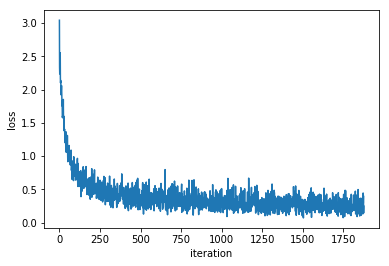

In [19]:
learner.recorder!.plotLosses()

### Progress bar

It's nice to keep track of where we're at in the training with a progress bar.

In [20]:
// export
import Foundation

In [21]:
// export
func formatTime(_ t: Float) -> String {
    let t = Int(t)
    let (h,m,s) = (t/3600, (t/60)%60, t%60)
    return h != 0 ? String(format: "%02d:%02d:%02d", h, m, s) : String(format: "%02d:%02d", m, s)
}

In [22]:
formatTime(78.23)

"01:18"


In [23]:
// export
public struct ProgressBar{
    let total: Int
    let length: Int = 50
    let showEvery: Float = 0.02
    let fillChar: Character = "X"
    public var comment: String = ""
    private var lastVal: Int = 0
    private var waitFor: Int = 0
    private var startTime: UInt64 = 0
    private var lastShow: UInt64 = 0
    private var estimatedTotal: Float = 0.0
    private var bar: String = ""
    
    public init(_ c: Int) { total = c }
    
    public mutating func update(_ val: Int){
        if val == 0 {
            startTime = DispatchTime.now().uptimeNanoseconds
            lastShow = startTime
            waitFor = 1
            update_bar(0)
        } else if val >= lastVal + waitFor || val == total {
            lastShow = DispatchTime.now().uptimeNanoseconds
            let averageTime = Float(lastShow - startTime) / (1e9 * Float(val))
            waitFor = max(Int(averageTime / (showEvery + 1e-8)), 1)
            estimatedTotal = Float(total) * averageTime
            update_bar(val)
        }
    }
    
    public mutating func update_bar(_ val: Int){
        lastVal = val
        let prevLength = bar.count
        bar = String(repeating: fillChar, count: (val * length) / total)
        bar += String(repeating: "-", count: length - (val * length) / total)
        let pct = String(format: "%.2f", 100.0 * Float(val)/Float(total))
        let elapsedTime = Float(lastShow - startTime) / 1e9
        let remaingTime = estimatedTotal - elapsedTime
        bar += " \(pct)% [\(val)/\(total) \(formatTime(elapsedTime))<\(formatTime(remaingTime))"
        bar += comment.isEmpty ? "]" : " \(comment)]"
        if bar.count < prevLength { bar += String(repeating: " ", count: prevLength-bar.count) }
        print(bar, terminator:"\r")
        fflush(stdout)
    }
    
    public func remove(){
        print(String(repeating: " ", count: bar.count), terminator:"\r")
        fflush(stdout)
    }
}

In [24]:
var tst = ProgressBar(100)
for i in 0...100{
    tst.update(i)
    usleep(50000)
}
tst.remove()

In [25]:
// export
extension Learner {
    public class ShowProgress: Delegate {
        var pbar: ProgressBar? = nil
        var iter: Int = 0
        
        public override func epochWillStart(learner: Learner) {
            pbar = ProgressBar(learner.data.train.count)
        }
        
        public override func validationWillStart(learner: Learner) {
            if pbar != nil { pbar!.remove() }
            pbar = ProgressBar(learner.data.valid.count)
        }
        
        public override func epochDidFinish(learner: Learner) {
            if pbar != nil { pbar!.remove() }
        }
        
        public override func batchWillStart(learner: Learner) {
            if learner.currentIter == 0 {pbar!.update(0)}
        }
        
        public override func batchDidFinish(learner: Learner) {
            pbar!.update(learner.currentIter)
        }
        
        public override func trainingDidFinish(learner: Learner) {
            if pbar != nil { pbar!.remove() }
        }
    }
    
    public func makeShowProgress() -> ShowProgress { return ShowProgress() }
}

In [29]:
let learner = Learner(data: data, lossFunc: softmaxCrossEntropy, optFunc: optFunc, modelInit: modelInit)

In [30]:
learner.delegates = [learner.makeTrainEvalDelegate(), learner.makeShowProgress(), 
                     learner.makeAvgMetric(metrics: [accuracy]), learner.makeRecorder(),
                     learner.makeNormalize(mean: mnistStats.mean, std: mnistStats.std)]

In [31]:
learner.fit(2)

Epoch 0: [0.29616672, 0.9156]                                                   
Epoch 1: [0.23857039, 0.9304]                                                   


### Annealing

In [32]:
// export
/// A non-generalized learning rate scheduler
extension Learner where Opt.Scalar: BinaryFloatingPoint {
    public class ParamScheduler: Delegate {
        public override var order: Int { return 1 }
        public typealias ScheduleFunc = (Float) -> Float

        // A learning rate schedule from step to float.
        public var scheduler: ScheduleFunc
        
        public init(scheduler: @escaping (Float) -> Float) {
            self.scheduler = scheduler
        }
        
        override public func batchWillStart(learner: Learner) {
            learner.opt.learningRate = Opt.Scalar(scheduler(learner.pctEpochs/Float(learner.epochCount)))
        }
    }
    
    public func makeParamScheduler(scheduler: @escaping (Float) -> Float) -> ParamScheduler {
        return ParamScheduler(scheduler: scheduler)
    }
}

In [33]:
// export
public func linearSchedule(start: Float, end: Float, pct: Float) -> Float {
    return start + pct * (end - start)
}

public func makeAnnealer(start: Float, end: Float, schedule: @escaping (Float, Float, Float) -> Float) -> (Float) -> Float { 
    return { pct in return schedule(start, end, pct) }
}

In [34]:
let annealer = makeAnnealer(start: 1e-2, end: 0.1, schedule: linearSchedule)
annealer(0.3)

0.037


In [35]:
let learner = Learner(data: data, lossFunc: softmaxCrossEntropy, optFunc: optFunc, modelInit: modelInit)
let recorder = learner.makeRecorder()

In [36]:
learner.delegates = [learner.makeTrainEvalDelegate(), learner.makeShowProgress(), 
                     learner.makeAvgMetric(metrics: [accuracy]), recorder,
                     learner.makeNormalize(mean: mnistStats.mean, std: mnistStats.std),
                     learner.makeParamScheduler(scheduler: annealer)]

In [37]:
learner.fit(2)

Epoch 0: [0.23219977, 0.9309]                                                   
Epoch 1: [0.17837457, 0.9446]                                                   


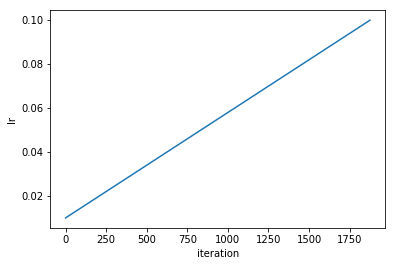

In [38]:
recorder.plotLRs()

More annealing functions

In [39]:
// export
public func constantSchedule(start: Float, end: Float, pct: Float) -> Float {
    return start
}

public func cosineSchedule(start: Float, end: Float, pct: Float) -> Float {
    return start + (1 + cos(Float.pi*(1-pct))) * (end-start) / 2
}

public func expSchedule(start: Float, end: Float, pct: Float) -> Float {
    return start * pow(end / start, pct)
}

In [40]:
// export
public func combineSchedules(pcts: [Float], schedules: [(Float) -> Float]) -> ((Float) -> Float){
    var cumPcts: [Float] = [0]
    for pct in pcts {cumPcts.append(cumPcts.last! + pct)}
    func inner(pct: Float) -> Float{
        if (pct == 0.0) { return schedules[0](0.0) }
        let i = cumPcts.firstIndex(where: {$0 >= pct})! - 1
        let actualPos = (pct-cumPcts[i]) / (cumPcts[i+1]-cumPcts[i])
        return schedules[i](actualPos)
    }
    return inner
}

In [41]:
let mySchedule = combineSchedules(pcts: [0.3, 0.7], 
                                  schedules: [makeAnnealer(start: 0.3, end: 0.6, schedule: cosineSchedule),
                                              makeAnnealer(start: 0.6, end: 0.2, schedule: cosineSchedule)])

In [42]:
let learner = Learner(data: data, lossFunc: softmaxCrossEntropy, optFunc: optFunc, modelInit: modelInit)
let recorder = learner.makeRecorder()

In [43]:
learner.delegates = [learner.makeTrainEvalDelegate(), learner.makeShowProgress(), 
                     learner.makeAvgMetric(metrics: [accuracy]), recorder,
                     learner.makeNormalize(mean: mnistStats.mean, std: mnistStats.std),
                     learner.makeParamScheduler(scheduler: mySchedule)]

In [44]:
learner.fit(2)

Epoch 0: [0.18290788, 0.9453]                                                   
Epoch 1: [0.12062283, 0.9655]                                                   


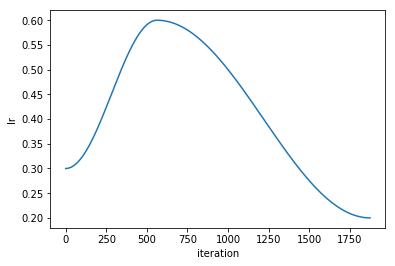

In [45]:
recorder.plotLRs()

In [ ]:
//Needs fixing 
//learner.recorder!.plotLRs()

## Export

In [46]:
notebookToScript(fname: (Path.cwd / "05_anneal.ipynb").string)